In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import time

from joblib import Parallel, delayed

%matplotlib inline
sns.set_style('darkgrid')

In [38]:
import os
import sys

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [39]:
from HDSIdent.data_treatment.data_preprocessing import Preprocessing
from HDSIdent.initial_intervals.exponential_weighted import ExponentialWeighted
from HDSIdent.initial_intervals.bandpass_filter import BandpassFilter
from HDSIdent.initial_intervals.non_parametric_pettitt import PettittMethod

### Read Data

#### NOTICE: this simulation data here presented was produced inspired in Exemple 3 of the following work:

<cite>WANG, J. et al. Searching historical data segments for process identification in feedback control loops. Computers and Chemical Engineering, v. 112, n. 6, p. 6–16, 2018.</cite>

In [40]:
u1 = pd.read_csv('mimo_simu_u1.csv',header=None)
u2 = pd.read_csv('mimo_simu_u2.csv',header=None)
y1 = pd.read_csv('mimo_simu_y1.csv',header=None)
y2 = pd.read_csv('mimo_simu_y2.csv',header=None)

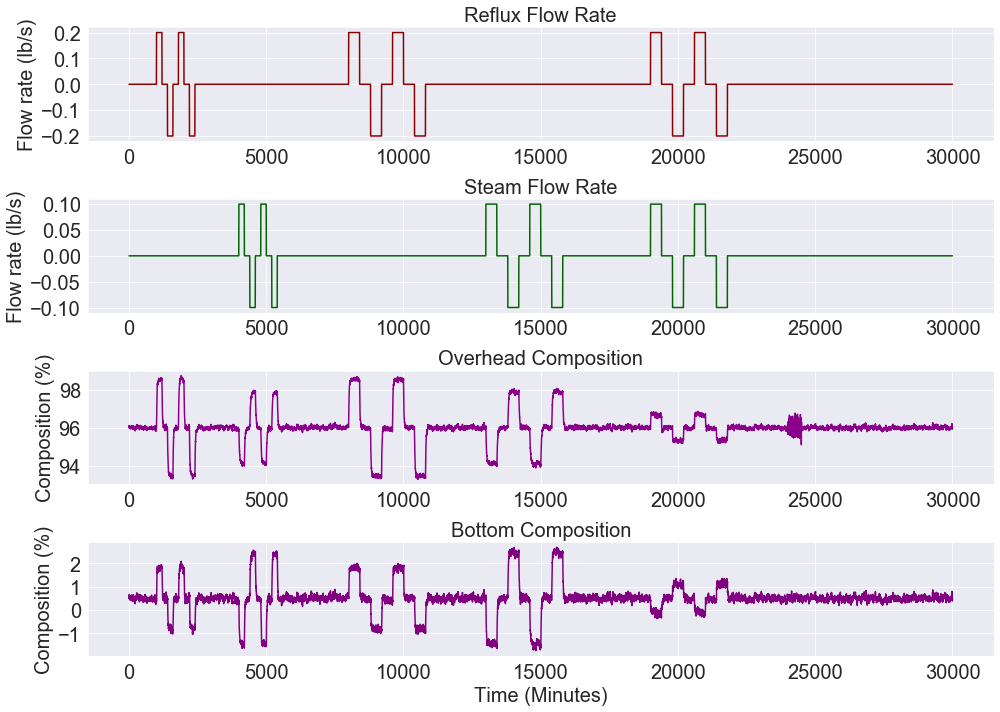

In [41]:
plt.figure(figsize=(14,10));

plt.subplot(4,1,1);
plt.plot(u1, color='darkred');
plt.title("Reflux Flow Rate", fontsize=20);
plt.ylabel("Flow rate (lb/s)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

plt.subplot(4,1,2);
plt.plot(u2, color='darkgreen');
plt.title("Steam Flow Rate", fontsize=20);
plt.ylabel("Flow rate (lb/s)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

plt.subplot(4,1,3);
plt.plot(y1, color='darkmagenta');
plt.title("Overhead Composition", fontsize=20);
plt.ylabel("Composition (%)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

plt.subplot(4,1,4);
plt.plot(y2,  color='purple');
plt.title("Bottom Composition", fontsize=20);
plt.ylabel("Composition (%)", fontsize=20);
plt.xlabel("Time (Minutes)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

plt.tight_layout();

### Data Pre-processing

In [42]:
pp = Preprocessing(
        scaler='MinMaxScaler',
        feature_range=(-0.5,0.5),
        k=100);

In [43]:
X_clean, Y_clean = pp.fit_transform(X=np.concatenate([u1,u2],axis=1),
                                    y=np.concatenate([y1,y2],axis=1))

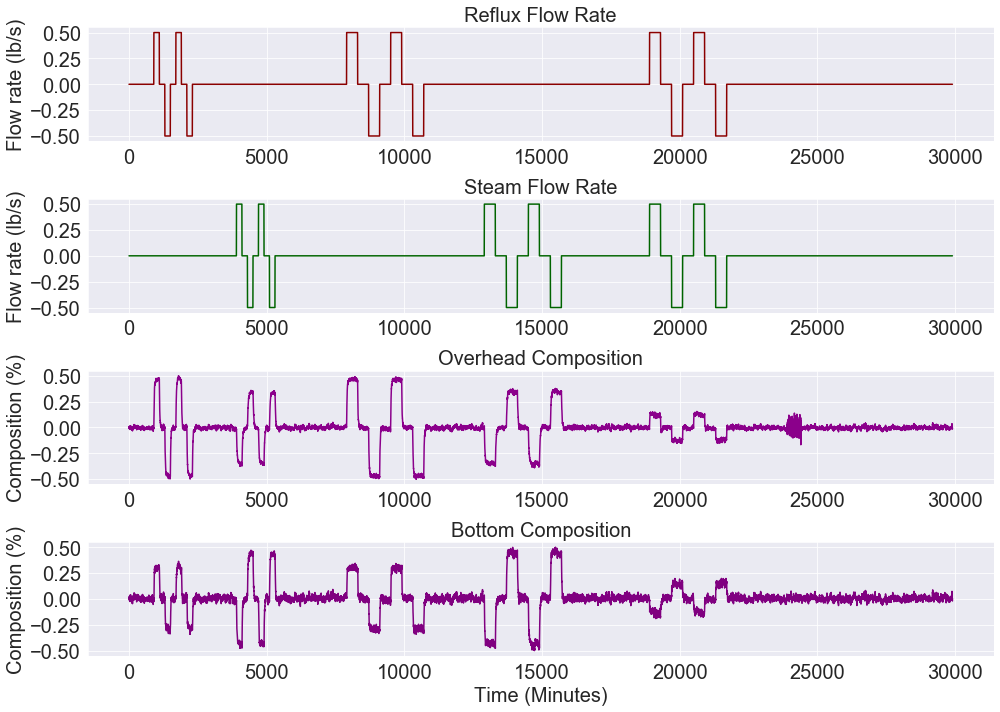

In [44]:
plt.figure(figsize=(14,10));

plt.subplot(4,1,1);
plt.plot(X_clean[:,0], color='darkred');
plt.title("Reflux Flow Rate", fontsize=20);
plt.ylabel("Flow rate (lb/s)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

plt.subplot(4,1,2);
plt.plot(X_clean[:,1], color='darkgreen');
plt.title("Steam Flow Rate", fontsize=20);
plt.ylabel("Flow rate (lb/s)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

plt.subplot(4,1,3);
plt.plot(Y_clean[:,0], color='darkmagenta');
plt.title("Overhead Composition", fontsize=20);
plt.ylabel("Composition (%)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

plt.subplot(4,1,4);
plt.plot(Y_clean[:,1],  color='purple');
plt.title("Bottom Composition", fontsize=20);
plt.ylabel("Composition (%)", fontsize=20);
plt.xlabel("Time (Minutes)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

plt.tight_layout();

### Potential Intervals

#### 1) Exponential Weighted Filter

**Finding potential intervals with the Set-point and the Output Variable**

In [45]:
df = pd.DataFrame()
df['U1'] = np.squeeze(X_clean[:,0])
df['U2'] = np.squeeze(X_clean[:,1])
df['Y1'] = np.squeeze(Y_clean[:,0])
df['Y2'] = np.squeeze(Y_clean[:,1])

In [46]:
df.head()

,U1,U2,Y1,Y2
0,0.0,0.0,0.003292,0.016390
1,0.0,0.0,0.002377,0.014547
2,0.0,0.0,0.004389,0.018323
3,0.0,0.0,-0.000914,0.008537
4,0.0,0.0,-0.004389,0.002412


In [47]:
EW = ExponentialWeighted(forgetting_fact_v = np.array([0.006,0.006,0.006,0.006]),
                         forgetting_fact_u = np.array([0.006,0.006,0.006,0.006]),
                         H_v = [0.005,0.005,0.005,0.005],
                         num_previous_indexes=0,
                         verbose=0,
                         n_jobs=-1);

In [48]:
start = time()
EW.fit(X=df[['U1','U2']], y=df[['Y1','Y2']]);
end = time()

In [49]:
print("Execution Time: {}".format(end-start))

Execution Time: 9.799662113189697


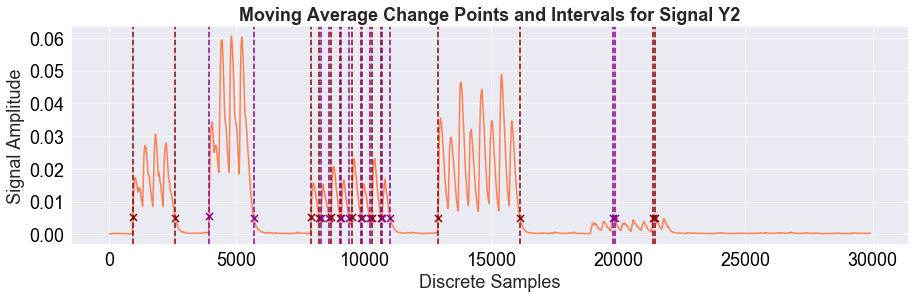

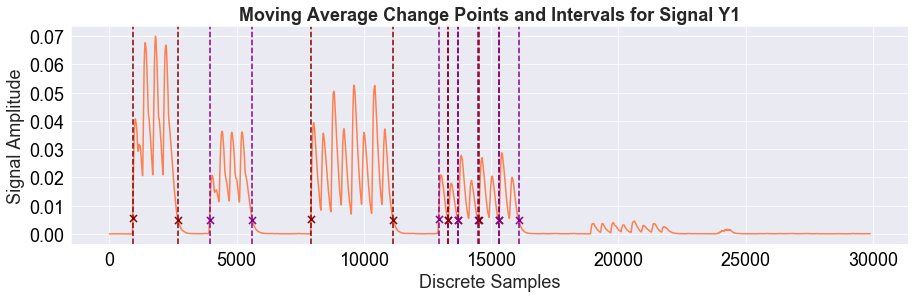

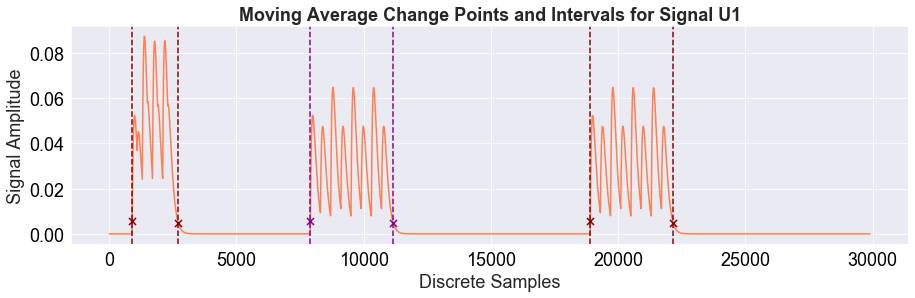

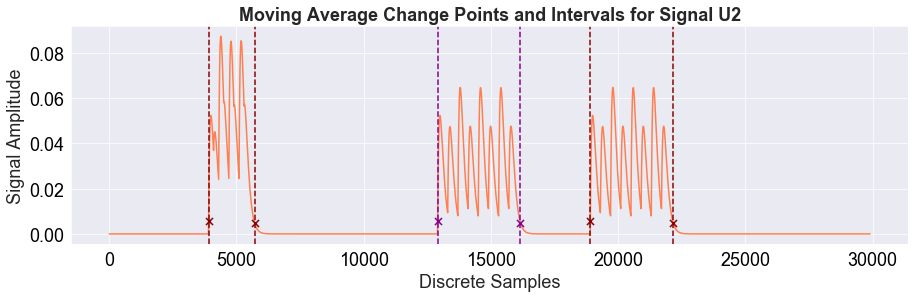

In [13]:
EW.plot_change_points(X=df[['U1','U2']], y=df[['Y1','Y2']])

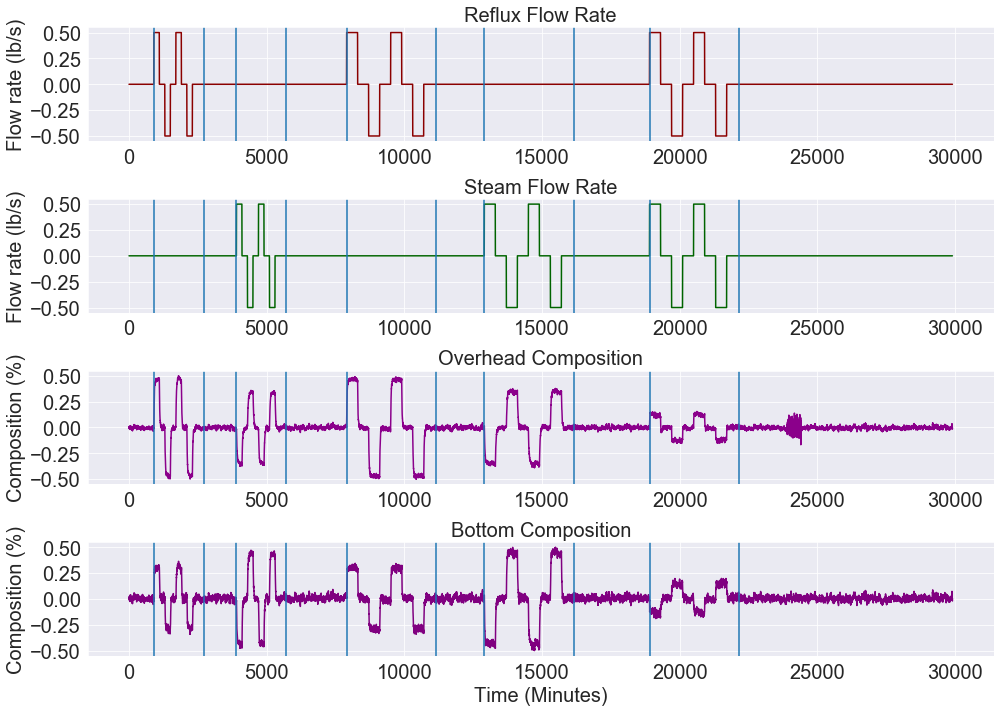

In [14]:
plt.figure(figsize=(14,10));

plt.subplot(4,1,1);
plt.plot(X_clean[:,0], color='darkred');
plt.title("Reflux Flow Rate", fontsize=20);
plt.ylabel("Flow rate (lb/s)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
for key, interval in EW.unified_intervals.items():
    plt.axvline(np.min(interval))
    plt.axvline(np.max(interval))
    
plt.subplot(4,1,2);
plt.plot(X_clean[:,1], color='darkgreen');
plt.title("Steam Flow Rate", fontsize=20);
plt.ylabel("Flow rate (lb/s)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
for key, interval in EW.unified_intervals.items():
    plt.axvline(np.min(interval))
    plt.axvline(np.max(interval))
    
plt.subplot(4,1,3);
plt.plot(Y_clean[:,0], color='darkmagenta');
plt.title("Overhead Composition", fontsize=20);
plt.ylabel("Composition (%)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
for key, interval in EW.unified_intervals.items():
    plt.axvline(np.min(interval))
    plt.axvline(np.max(interval))
    
plt.subplot(4,1,4);
plt.plot(Y_clean[:,1],  color='purple');
plt.title("Bottom Composition", fontsize=20);
plt.ylabel("Composition (%)", fontsize=20);
plt.xlabel("Time (Minutes)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
for key, interval in EW.unified_intervals.items():
    plt.axvline(np.min(interval))
    plt.axvline(np.max(interval))
    
plt.tight_layout();

### Effect of the Filter in Step Responses

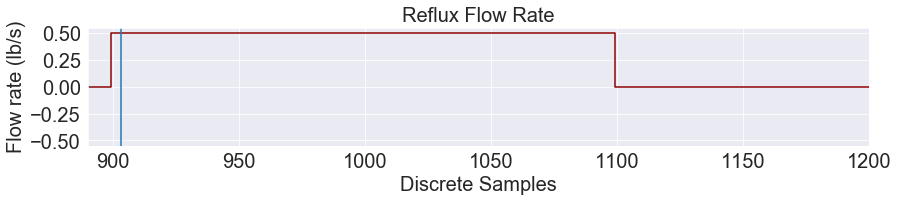

In [33]:
plt.figure(figsize=(14,10));

plt.subplot(4,1,1);
plt.step(range(0,len(X_clean[:,0])),X_clean[:,0], color='darkred');
plt.title("Reflux Flow Rate", fontsize=20);
plt.ylabel("Flow rate (lb/s)", fontsize=20);
plt.xlabel("Discrete Samples", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
for key, interval in EW.unified_intervals.items():
    plt.axvline(np.min(interval))
    plt.axvline(np.max(interval))
plt.xlim([890,1200]);

#### Including Previous Indexes

In [34]:
EW = ExponentialWeighted(forgetting_fact_v = np.array([0.006,0.006,0.006,0.006]),
                         forgetting_fact_u = np.array([0.006,0.006,0.006,0.006]),
                         H_v = [0.005,0.005,0.005,0.005],
                         num_previous_indexes=50,
                         verbose=0,
                         n_jobs=-1);
EW.fit(X=df[['U1','U2']], y=df[['Y1','Y2']]);

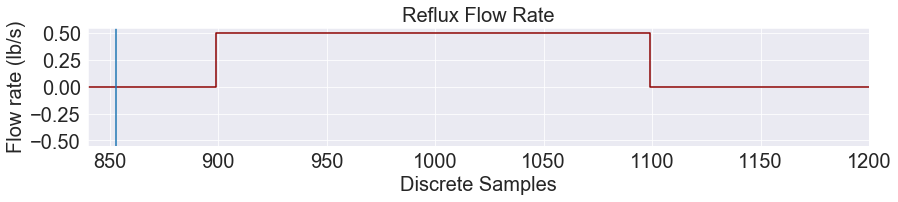

In [36]:
plt.figure(figsize=(14,10));

plt.subplot(4,1,1);
plt.step(range(0,len(X_clean[:,0])),X_clean[:,0], color='darkred');
plt.title("Reflux Flow Rate", fontsize=20);
plt.ylabel("Flow rate (lb/s)", fontsize=20);
plt.xlabel("Discrete Samples", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
for key, interval in EW.unified_intervals.items():
    plt.axvline(np.min(interval))
    plt.axvline(np.max(interval))
plt.xlim([840,1200]);

**Verifying the effect of the Forgetting Factor**

In [65]:
forget_fact_arr = np.array([0.0005, 0.002, 0.005])

count = 0
S_plot_arr = []
mu_plot_arr = []
for fact in forget_fact_arr:
    count+=1
    print("Iteration {}/{}".format(count,len(forget_fact_arr)))
    EW = ExponentialWeighted(X=df,
                             forgetting_fact_v = np.array([fact]*2),
                             forgetting_fact_u = np.array([fact]*2),
                             n_jobs=-1)
    EW.fit()
    S_plot_arr.append(EW._v_k_arr)
    mu_plot_arr.append(EW._mu_k_arr)

Iteration 1/3
Iteration 2/3
Iteration 3/3


#### Variance Filter

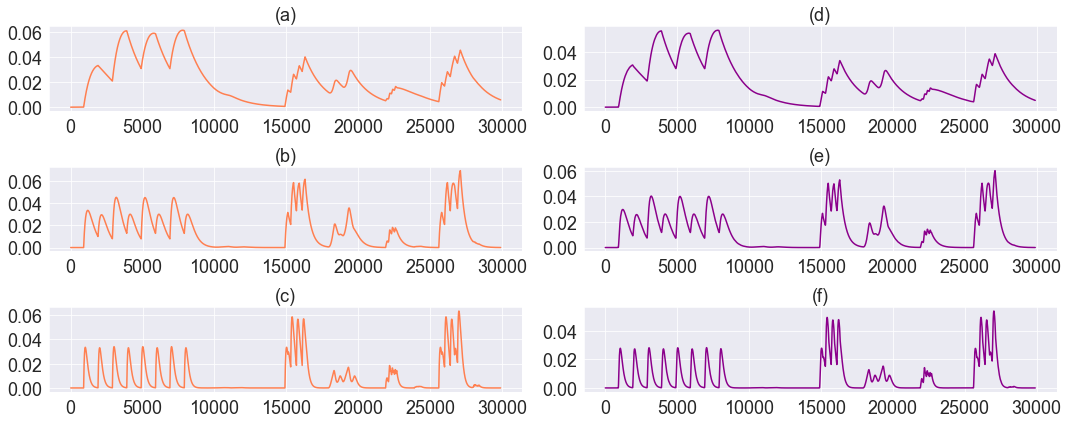

In [66]:
plt.figure(figsize=(15,6))

plt.subplot(3,2,1);
plt.plot(S_plot_arr[0][:,0], color='coral');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("(a)", fontsize=18);

plt.subplot(3,2,2);
plt.plot(S_plot_arr[0][:,1], color='darkmagenta');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("(d)", fontsize=18);

plt.subplot(3,2,3);
plt.plot(S_plot_arr[1][:,0], color='coral');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("(b)", fontsize=18);

plt.subplot(3,2,4);
plt.plot(S_plot_arr[1][:,1], color='darkmagenta');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("(e)", fontsize=18);

plt.subplot(3,2,5);
plt.plot(S_plot_arr[2][:,0], color='coral');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("(c)", fontsize=18);

plt.subplot(3,2,6);
plt.plot(S_plot_arr[2][:,1], color='darkmagenta');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("(f)", fontsize=18);

plt.tight_layout();

#### Average Filter

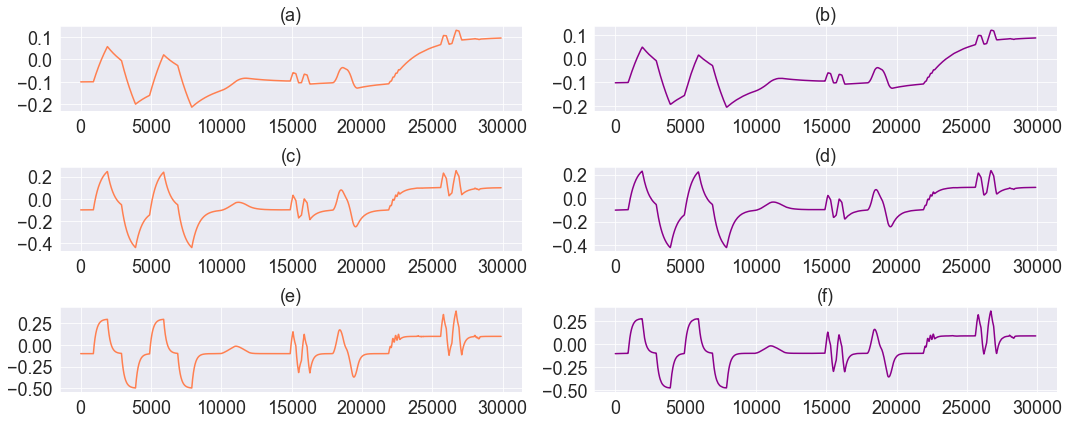

In [67]:
plt.figure(figsize=(15,6))

plt.subplot(3,2,1);
plt.plot(mu_plot_arr[0][:,0], color='coral');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("(a)", fontsize=18);

plt.subplot(3,2,2);
plt.plot(mu_plot_arr[0][:,1], color='darkmagenta');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("(b)", fontsize=18);

plt.subplot(3,2,3);
plt.plot(mu_plot_arr[1][:,0], color='coral');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("(c)", fontsize=18);

plt.subplot(3,2,4);
plt.plot(mu_plot_arr[1][:,1], color='darkmagenta');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("(d)", fontsize=18);

plt.subplot(3,2,5);
plt.plot(mu_plot_arr[2][:,0], color='coral');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("(e)", fontsize=18);

plt.subplot(3,2,6);
plt.plot(mu_plot_arr[2][:,1], color='darkmagenta');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title("(f)", fontsize=18);

plt.tight_layout();

**Choosing Parameters**

In [81]:
EW = ExponentialWeighted(X=df,
                         forgetting_fact_v = np.array([0.006,0.006]),
                         forgetting_fact_u = np.array([0.006,0.006]),
                         H_v = [0.003,0.003],
                         verbose=0,
                         n_jobs=-1)

In [82]:
EW.fit();

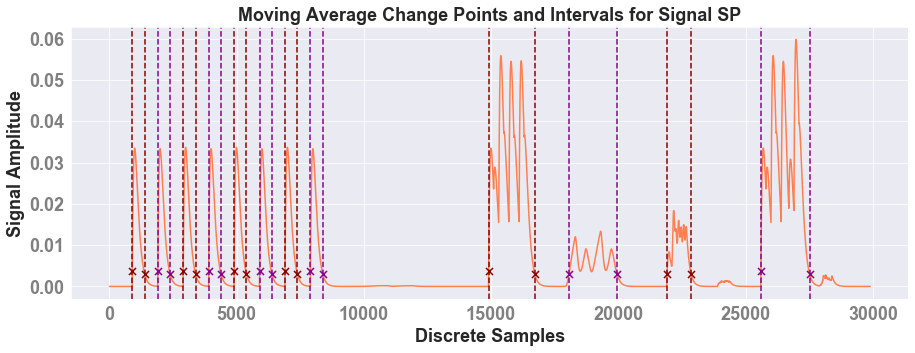

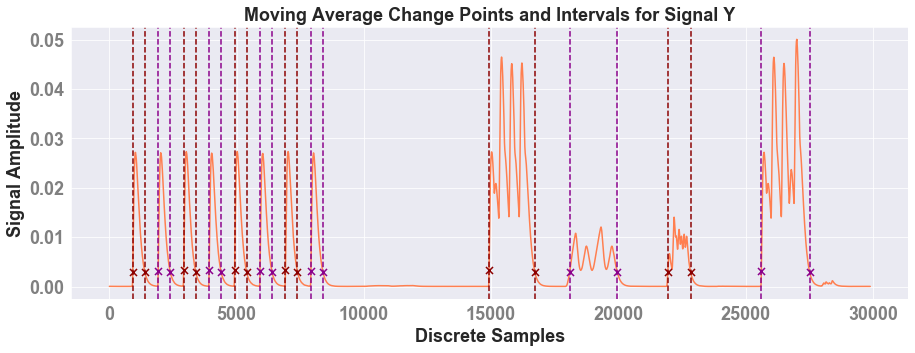

In [83]:
EW.plot_change_points()

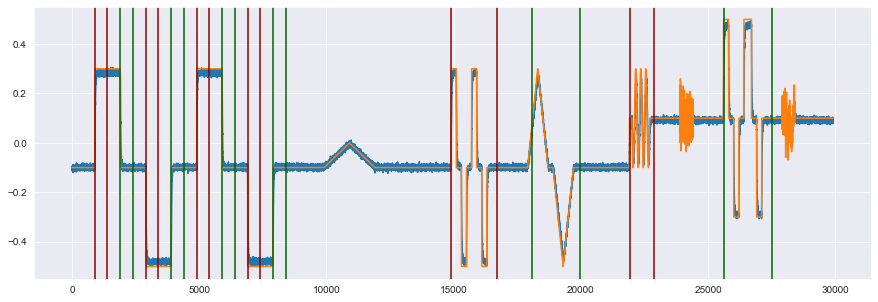

In [84]:
plt.figure(figsize=(15,5))
plt.plot(Y_clean);
plt.plot(X_clean[:,1]);

counter = 2;
for key, interval in EW.unified_intervals.items():
    if counter%2==0:
        color = 'darkred'
    else:
        color = 'darkgreen'
        
    plt.axvline(np.min(interval),color=color);
    plt.axvline(np.max(interval),color=color);
    
    counter+=1

#### 2) Pettitt Change-point Method

In [56]:
PM = PettittMethod(alpha=0.05,
                   min_length_to_split=1200,
                   verbose=0,
                   n_jobs=1)

In [57]:
pm_initial_segments = PM.fit(X=sp,
                             y=y)

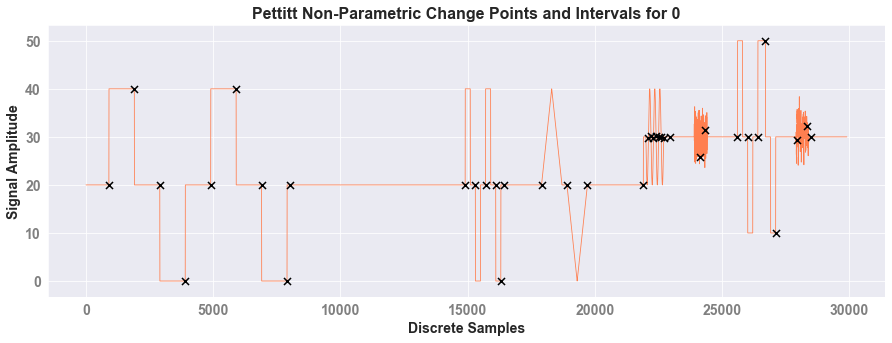

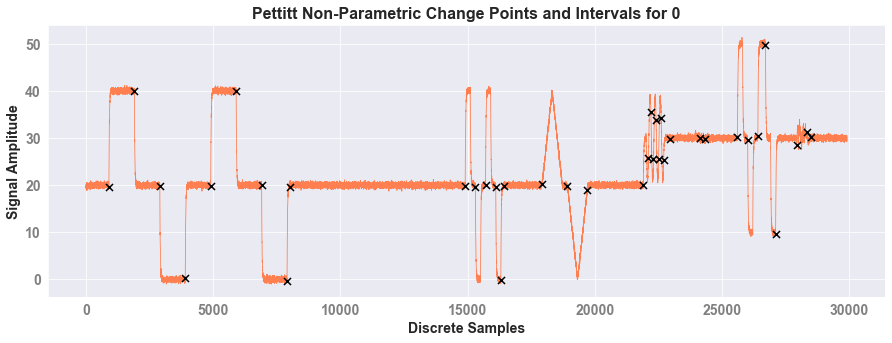

In [58]:
PM.plot_change_points(X=sp,y=y)

#### 3) Bandpass Filter

In [229]:
BP = BandpassFilter(
       X=pd.DataFrame(df),
       W=[0.006, 0.04],
       H=[0.02]*2,
       N=1
    )

In [230]:
BP.fit();

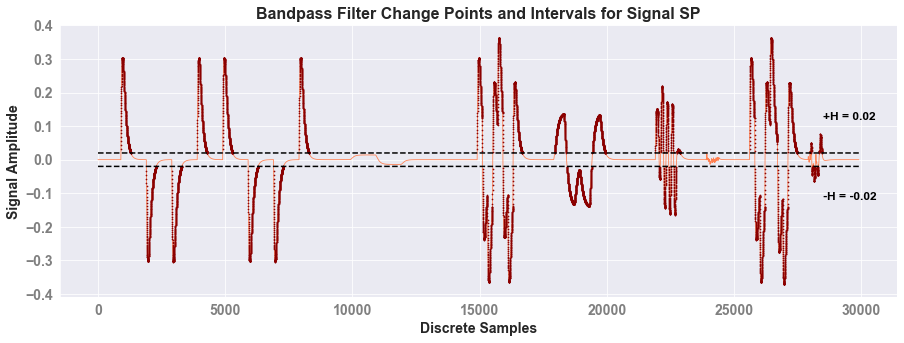

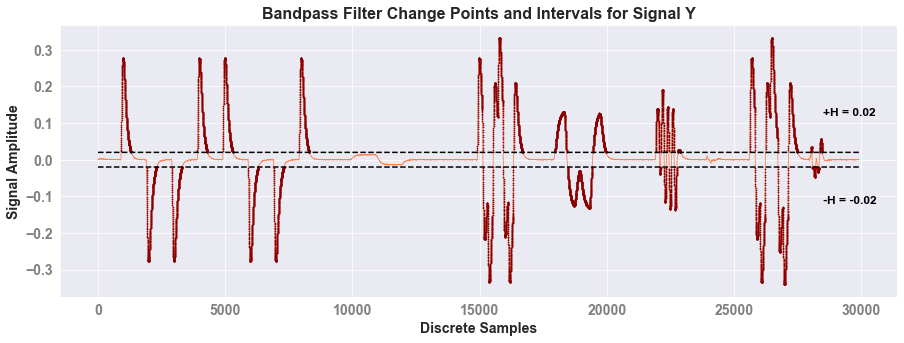

In [231]:
BP.plot_change_points()

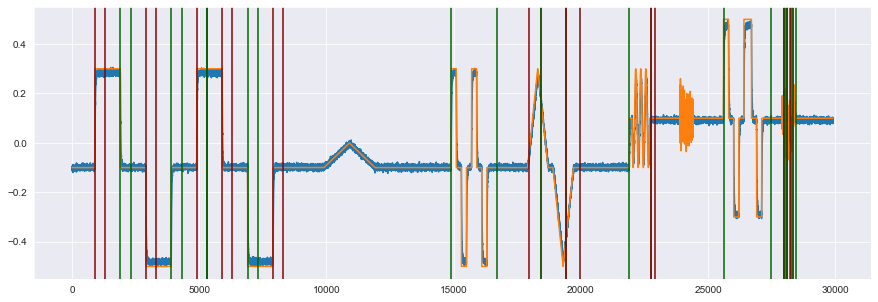

In [232]:
plt.figure(figsize=(15,5))
plt.plot(Y_clean);
plt.plot(X_clean[:,1]);

counter = 2;
for key, interval in BP.unified_intervals.items():
    if counter%2==0:
        color = 'darkred'
    else:
        color = 'darkgreen'
        
    plt.axvline(np.min(interval),color=color);
    plt.axvline(np.max(interval),color=color);
    
    counter+=1